# 0. Подготовка данных (1 балл)

Данные представляют собой набор первых 10 букв от A до J латинского алфавита (каждая буква - класс), написанных разными шрифтами. Ваша задача - написать классификатор для этих данных, определяющий буквы на изображении

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-01-30 19:34:27--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  60.3MB/s    in 4.0s    

2021-01-30 19:34:31 (58.5 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [2]:
DATA_DIR = 'notMNIST_large/'

In [3]:
# Delete incorrect files

from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
    os.remove(img_path)

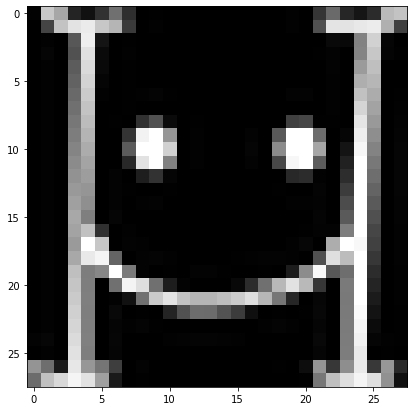

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(7,7))
letter = 'H'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[1]))
plt.imshow(img)

In [5]:
img = Image.open(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[1]))
w,h=img.size
print(w, h)

28 28


# Модель (3 балла)

In [15]:
import os
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    InputLayer,
    BatchNormalization,
    Dropout
)
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def make_model(n_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.1))

    # 2 Convolution
    model.add(Conv2D(32, padding="same", kernel_size=(3, 3)))
    model.add(LeakyReLU(0.1))

    # MaxPooling
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25, noise_shape=None, seed=0))

    # 3 Convolution
    model.add(Conv2D(32, padding="same", kernel_size=(3, 3)))
    model.add(LeakyReLU(0.1))
    
    # MaxPooling
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    # 4 convolution
    model.add(Conv2D(64, padding="same", kernel_size=(3, 3)))
    model.add(LeakyReLU(0.1))
    
    #2 MaxPooling
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25, noise_shape=None, seed=0))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5, noise_shape=None, seed=0))

    model.add(Dense(n_classes, activation="softmax"))
    # compile model
    opt = keras.optimizers.Adam(learning_rate=0.00015)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Аугментация данных (3 балла)

train/val split должен быть 9/1 !

In [7]:
"""Подсказка: train/val split удобно делать вот так:
stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in
(самый залайканый ответ)"""

""" Data generators initialization: for train and validation sets """
batch_size = 32  # Try to change it later

generator = ImageDataGenerator(rescale=(1.0 / 255), validation_split=0.1, zoom_range=0.2, shear_range=0.1)

train_generator = generator.flow_from_directory(
    DATA_DIR, target_size=(28, 28), color_mode="grayscale", batch_size=batch_size, subset="training"
)

valid_generator = generator.flow_from_directory(
    DATA_DIR, target_size=(28, 28), color_mode="grayscale", batch_size=batch_size, subset="validation"
)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


In [16]:
n_classes = len(os.listdir(DATA_DIR))
model = make_model(n_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9

# Обучение модели

val_accuracy > 0.85 - 1 балл

val_accuracy > 0.88 - 2 балла

val_accuracy > 0.91 - 3 балла

val_accuracy > 0.92 - 4 балла


**Максимальный суммарный балл** - 11

**Финальная оценка**: min(суммарный балл, 10)


In [17]:
EPOCHS = 10

K.clear_session()

In [18]:
step_size_train = (train_generator.n // train_generator.batch_size)
step_size_valid = (valid_generator.n // valid_generator.batch_size)

In [19]:
model.fit_generator(
    train_generator,  # prepared data
    steps_per_epoch=step_size_train,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
14881/14881 [==============================] - 240s 16ms/step - loss: 0.7700 - accuracy: 0.7589 - val_loss: 0.2849 - val_accuracy: 0.9137
Epoch 2/10
14881/14881 [==============================] - 238s 16ms/step - loss: 0.3831 - accuracy: 0.8838 - val_loss: 0.2519 - val_accuracy: 0.9229
Epoch 3/10
14881/14881 [==============================] - 236s 16ms/step - loss: 0.3377 - accuracy: 0.8966 - val_loss: 0.2330 - val_accuracy: 0.9278
Epoch 4/10
14881/14881 [==============================] - 236s 16ms/step - loss: 0.3146 - accuracy: 0.9034 - val_loss: 0.2190 - val_accuracy: 0.9328
Epoch 5/10
14881/14881 [==============================] - 236s 16ms/step - loss: 0.2988 - accuracy: 0.9081 - val_loss: 0.2148 - val_accuracy: 0.9341
Epoch 6/10
14881/14881 [==============================] - 235s 16ms/step - loss: 0.2865 - accuracy: 0.9118 - val_loss: 0.2088 - val_accuracy: 0.9354
Epoch 7/10
14881/14881 [==============================] - 234s 16ms/step - loss: 0.2814 - accuracy: 0.9126

In [21]:
# Получили val_accuracy = 0.9401 на 10-ой эпохе